In [1]:
import numpy as np
import pandas as pd
import bt
import matplotlib.pyplot as plt
%matplotlib inline

from Algo_Helpers import Signal, WeighFromSignal, Rebalance
start_date = '2010-11-01'


In [10]:
pdf = bt.get('aapl,msft,c,ge,gs,gold,spy', start=start_date)
pdf = pdf.pct_change(1) # 1 for ONE DAY lookback
pdf = pdf.dropna()

In [11]:
import cvxpy as cp


In [12]:
labels = list(pdf.columns)


# compute covariance matrix
Sigma = np.cov(pdf.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = pdf.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

ret = mu.T @ w
vol = cp.quad_form(w, Sigma)


z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')


,aapl,msft,c,ge,gs,gold,spy
rows,,,,,,,
real return,0.001135,0.001011,0.000374,0.000130,0.000472,0.000008,0.000559
vol,0.017894,0.016251,0.021933,0.020272,0.018267,0.025269,0.010871


In [15]:
prob = cp.Problem(cp.Minimize(vol),
                [cp.sum(w) == 1,
                w >= 0]
                )

prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
minvol = vol.value

print("Min return portfolio weights")
pd.DataFrame([wts], columns=labels)

Min return portfolio weights


,aapl,msft,c,ge,gs,gold,spy
0,-0.0,-0.0,-0.0,-0.0,-0.0,0.119,0.881


In [16]:
prob = cp.Problem(cp.Maximize(ret),  # maximize return
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value

print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)

Max return portfolio weights


,aapl,msft,c,ge,gs,gold,spy
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)


CPU times: total: 406 ms
Wall time: 408 ms


In [18]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
ret_df

,i,vol,return,std,aapl,msft,c,ge,gs,gold,spy
0,0,0.000109,0.000493,0.010417,1.782873e-08,1.705395e-08,4.318554e-09,2.038516e-08,8.845260e-09,1.188599e-01,8.811400e-01
1,1,0.000110,0.000519,0.010468,2.251375e-02,4.767772e-08,2.773438e-09,7.249116e-09,5.672226e-09,9.525734e-02,8.822288e-01
2,2,0.000111,0.000536,0.010519,4.008192e-02,8.390742e-03,8.863312e-10,1.807563e-09,1.694383e-09,9.102062e-02,8.605067e-01
3,3,0.000112,0.000550,0.010569,5.165830e-02,2.171054e-02,1.753645e-09,3.799208e-09,3.499548e-09,8.819076e-02,8.384404e-01
4,4,0.000113,0.000563,0.010619,6.214278e-02,3.378264e-02,8.653072e-10,2.172298e-09,1.798488e-09,8.562519e-02,8.184494e-01
...,...,...,...,...,...,...,...,...,...,...,...
195,195,0.000316,0.001133,0.017774,9.856519e-01,1.434784e-02,5.250939e-08,3.992602e-08,6.149032e-08,3.618674e-08,7.432412e-08
196,196,0.000317,0.001134,0.017804,9.892682e-01,1.073148e-02,6.866400e-08,5.326866e-08,7.533078e-08,4.595694e-08,8.661026e-08
197,197,0.000318,0.001134,0.017834,9.928619e-01,7.137356e-03,1.477320e-07,1.123172e-07,1.709432e-07,1.002643e-07,2.058552e-07
198,198,0.000319,0.001134,0.017864,9.964340e-01,3.563401e-03,5.128571e-07,3.852036e-07,6.236987e-07,3.571093e-07,7.677981e-07


Index(['aapl', 'msft', 'c', 'ge', 'gs', 'gold', 'spy'], dtype='object')

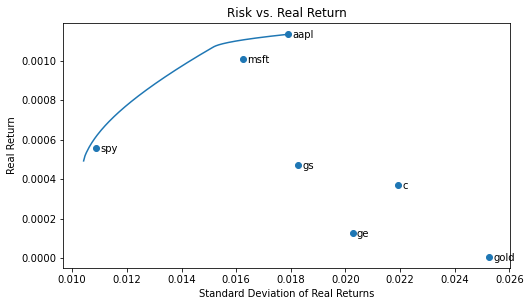

In [39]:
# plot efficient frontier
def plot_efrontier(ret_df, df,
                   xlabel="Standard Deviation of Real Returns",
                   ylabel="Real Return",
                   title=None):

    Sigma = np.cov(df.transpose())
    n = Sigma.shape[0]
    mu = df.mean().values
    asset_vols = np.sqrt(Sigma.diagonal())

    plt.figure(figsize=(8, 4.5))

    # plot the data
    plt.plot(ret_df['std'], ret_df['return'])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plot_title = "Risk vs. Real Return"
    plt.title(plot_title)

    # plot the markers
    plt.scatter(asset_vols, mu)
    xoffset = 0.00015
    yoffset = 0.00002
    labels = df.columns
    display(labels)
    for i, label in enumerate(labels):
        plt.annotate(label, xy=(asset_vols[i]+xoffset, mu[i]+yoffset),  xycoords='data',
                     horizontalalignment='left', verticalalignment='top',
                    )


plot_efrontier(ret_df, pdf)


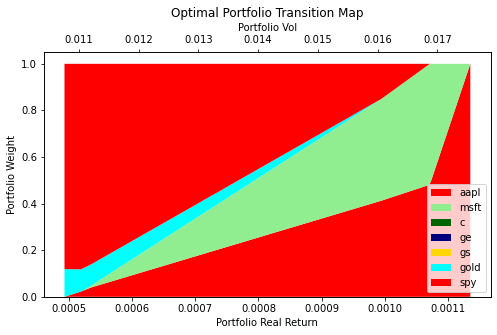

In [42]:
# stacked area chart of weights vs. returns
# for given vol constraint and corresponding real return, show portfolio weights
def transition_map(ret_df, labels, startyear, endyear):
    
    x = ret_df['return']
    # absolute values so shorts don't create chaos
    y_list = [abs(ret_df[l]) for l in labels]
    pal = ['red', 'lightgreen', 'darkgreen', 'navy', 'gold', 'cyan']
    
    fig = plt.figure(figsize=(8, 4.5))
    ax1 = fig.add_subplot(111)

    ax1.stackplot(x, y_list, labels=labels, colors=pal)
    ax1.set_xlabel("Portfolio Real Return")
    ax1.set_ylabel("Portfolio Weight")
    ax1.legend(loc='lower right')
    ax2 = ax1.twiny()
    ax2.set_xlim((ret_df['std'].iloc[0], ret_df['std'].iloc[-1]))
    ax2.set_xlabel('Portfolio Vol')
    
    
    plt.title("Optimal Portfolio Transition Map")

transition_map(ret_df, labels=pdf.columns, startyear=pdf.index[0], endyear=pdf.index[-1])

In [ ]:
pdf = bt.get('aapl,msft,c,ge,gs,gold,spy', start=start_date)

In [4]:
runMonthlyAlgo = bt.algos.RunWeekly()
rebalAlgo = Rebalance()

In [5]:
signalAlgo = Signal(pd.DateOffset(months=2),pd.DateOffset(days=1))
#signalAlgo = Signal()



In [6]:
weighFromSignalAlgo = WeighFromSignal()

In [7]:
s = bt.Strategy(
    'example1',
    [
        runMonthlyAlgo,
        signalAlgo,
        weighFromSignalAlgo,
        rebalAlgo
    ]
)
s.perm['tickers'] = list(pdf.columns)
t = bt.Backtest(s, pdf, integer_positions=False, progress_bar=True)
res = bt.run(t)

example1
0% [############################# ] 100% | ETA: 00:00:00

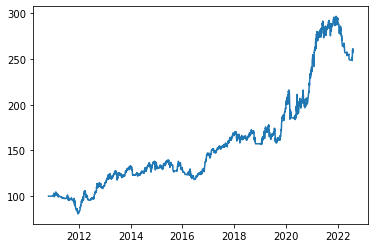

In [8]:
plt.plot(res.prices)
#pr = res.prices

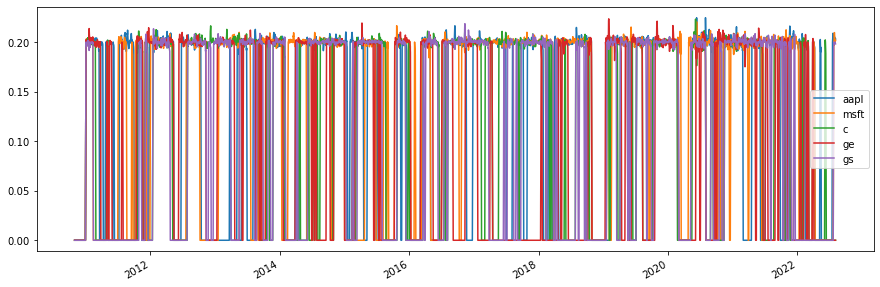

In [9]:
res.plot_security_weights()
#res.prices.tail()
#temp = res.get_security_weights()
#test = res.get_transactions()
#q = t.positions

In [10]:
df = pdf['aapl']

tmt = res.get_security_weights()['aapl']
tmt = tmt.rename("weight")
tmt = tmt.drop(tmt.index[0])
rdf = pd.concat([df, tmt], axis=1)
rdf['label'] = np.where(rdf['weight'] == 0, -1, 1)

""


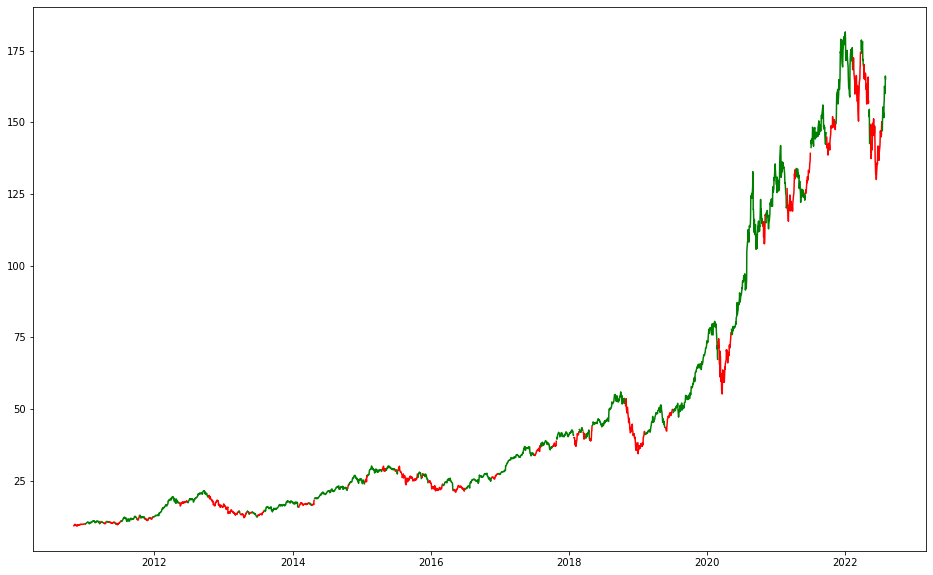

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(16,10)
def plot_func(group):
    global ax
    color = 'r' if (group['label'] < 0).all() else 'g'
    lw = 1.5
    ax.plot(group.index, group.aapl, c=color, linewidth=lw)


rdf.groupby((rdf['label'].shift() * rdf['label'] < 0).cumsum()).apply(plot_func)


In [12]:
res.stats


,example1
start,2010-10-31 00:00:00
end,2022-08-04 00:00:00
rf,0.0
total_return,1.606359
cagr,0.084875
max_drawdown,-0.228226
calmar,0.371891
mtd,0.003023
three_month,0.014554
six_month,-0.080923
